-5.0
Upper OuterCoil: I= 0.000, V = 0.267795+2.756924j 
Lower OuterCoil: I= 0.000, V = 0.410582+4.732629j 
InnerCoil: I= 0.020, V = 1.25036462+11.52928753j 
-4.5
Upper OuterCoil: I= 0.000, V = 0.275222+2.849413j 
Lower OuterCoil: I= 0.000, V = 0.404626+4.642244j 
InnerCoil: I= 0.020, V = 1.25035252+11.50996992j 
-4.0
Upper OuterCoil: I= 0.000, V = 0.282624+2.944154j 
Lower OuterCoil: I= 0.000, V = 0.398326+4.549511j 
InnerCoil: I= 0.020, V = 1.25036043+11.51457955j 
-3.5
Upper OuterCoil: I= 0.000, V = 0.290082+3.040669j 
Lower OuterCoil: I= 0.000, V = 0.391829+4.454606j 
InnerCoil: I= 0.020, V = 1.25042805+11.52159302j 
-3.0
Upper OuterCoil: I= 0.000, V = 0.297593+3.138665j 
Lower OuterCoil: I= 0.000, V = 0.385210+4.357528j 
InnerCoil: I= 0.020, V = 1.25039698+11.51878636j 
-2.5
Upper OuterCoil: I= 0.000, V = 0.305086+3.238166j 
Lower OuterCoil: I= 0.000, V = 0.378385+4.258774j 
InnerCoil: I= 0.020, V = 1.25039846+11.52533371j 
-2.0
Upper OuterCoil: I= 0.000, V = 0.312627+3.338749j 
Lo

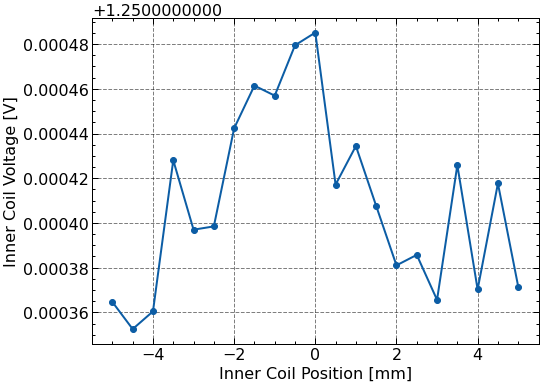

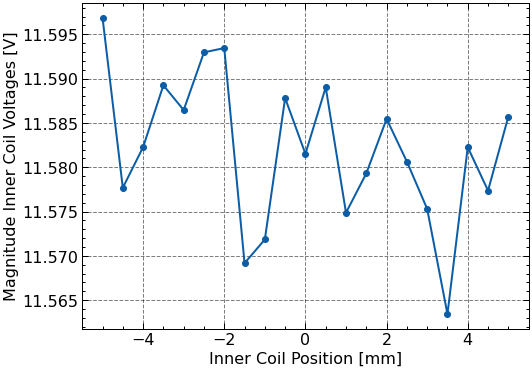

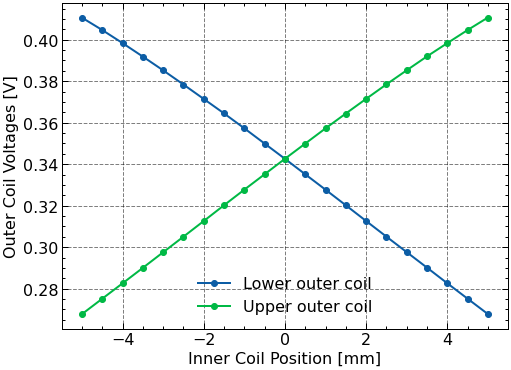

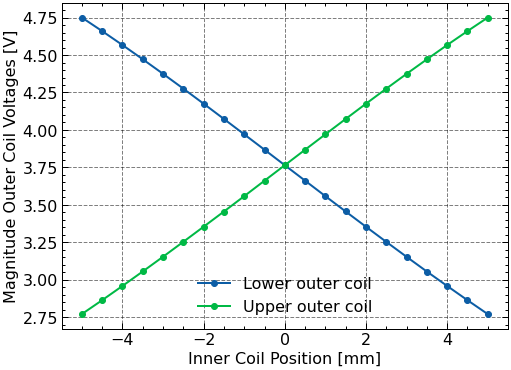

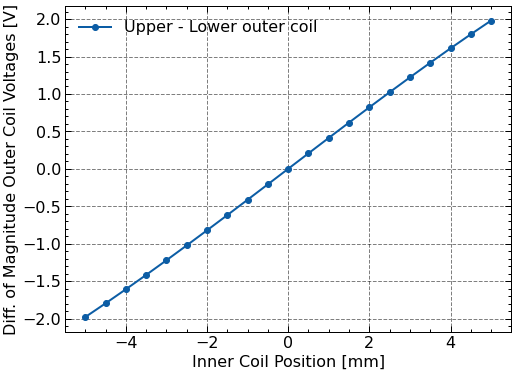

[1.46276738 1.46258852 1.46263082 1.46269035 1.46266688 1.4627277
 1.46272846 1.46249917 1.46252466 1.46267239 1.46261289 1.4626892
 1.46255495 1.46259897 1.46265892 1.46261333 1.46256502 1.46244825
 1.46262991 1.46257985 1.46266209]
[1.48425745 1.48385423 1.48346534 1.4830616  1.4826246  1.48218056
 1.48171119 1.48119163 1.48068878 1.48019292 1.47964931 1.47911844
 1.47853823 1.47797888 1.47742026 1.47683992 1.47623604 1.47563544
 1.47508515 1.4745043  1.47394884]
[1.47396472 1.47450585 1.47509451 1.47568342 1.4762639  1.47685807
 1.47743254 1.47796898 1.47853509 1.47911532 1.47965146 1.48019658
 1.48069567 1.48120872 1.48170045 1.48215993 1.48261292 1.48302607
 1.48346718 1.48385385 1.48424073]
Phase offset: -0.021490071911731468 -0.02157863574222607


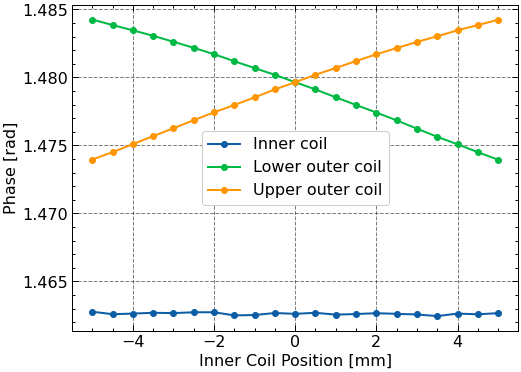

Fitted slope of the function: 40.204903054798976
[4.02049031e+01 1.32354748e-05]
Fitted slope of the function (-1,1): 41.3166748902232
fit (-1,1) is [4.13166749e+01 2.69355970e-03]
Fitted slope of the function (-2,2): 41.162567542139676
fit (-2,2) is  [4.11625675e+01 1.72209410e-03]
Fitted slope of the function (-3,3): 40.923581660455326
fit (-3,3) is [4.09235817e+01 1.01012735e-03]


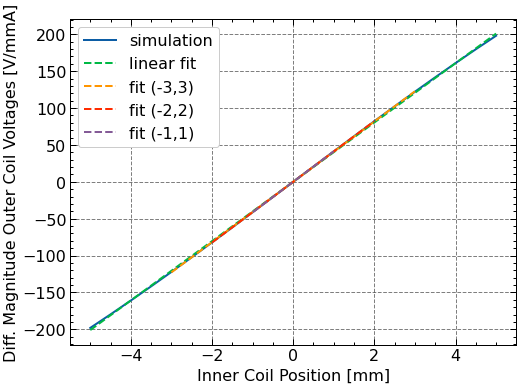

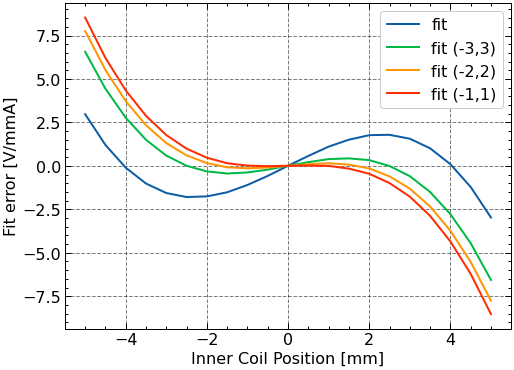

[-2.01024502e+02 -1.80922051e+02 -1.60819599e+02 -1.40717147e+02
 -1.20614696e+02 -1.00512244e+02 -8.04097929e+01 -6.03073413e+01
 -4.02048898e+01 -2.01024383e+01  1.32354748e-05  2.01024648e+01
  4.02049163e+01  6.03073678e+01  8.04098193e+01  1.00512271e+02
  1.20614722e+02  1.40717174e+02  1.60819625e+02  1.80922077e+02
  2.01024529e+02]
[-1.98050622e+02 -1.79717034e+02 -1.60922681e+02 -1.41733050e+02
 -1.22177967e+02 -1.02304407e+02 -8.21649899e+01 -6.18258691e+01
 -4.13024831e+01 -2.06770211e+01  4.82295362e-03  2.06749107e+01
  4.13132383e+01  6.18154754e+01  8.21774147e+01  1.02300983e+02
  1.22179024e+02  1.41730363e+02  1.60918048e+02  1.79708715e+02
  1.98053407e+02]


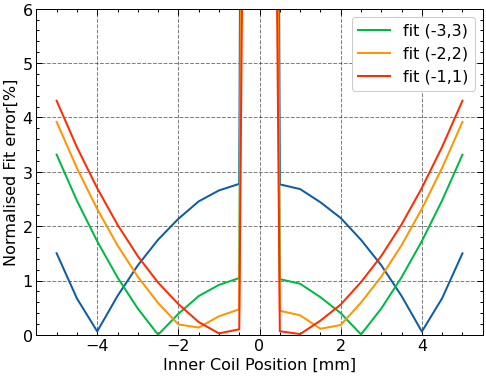

[1.50157580e+00 6.70507767e-01 6.40565680e-02 7.16771885e-01
 1.27950364e+00 1.75179454e+00 2.13618607e+00 2.45613647e+00
 2.65745099e+00 2.77884699e+00 9.97255733e+01 2.76879521e+00
 2.68272842e+00 2.43969257e+00 2.15095028e+00 1.74848034e+00
 1.28033586e+00 7.14870725e-01 6.11631135e-02 6.75182783e-01
 1.50016168e+00]


In [3]:
import design
import femm
import numpy as np
import cmath
import scipy.optimize as opt
import matplotlib.pyplot as plt
import os
import shutil
# The package must be initialized with the openfemm command.
femm.openfemm()
# We need to create a new Magnetostatics document to work on.
femm.newdocument(0)

outputfile = 'LVDT_10kHz_20mA_31AWG_10mm_6_7_7.out'
NSteps = 20
StepSize = 0.5
InnCoil_Offset = -5

sensor = design.Sensortype(0.02, 30000, 0)
femm.mi_probdef(sensor.para()[1], 'millimeters', 'axi', 1.0e-10)
wire = design.Wiretype("31 AWG", "31 AWG")
geo = design.Geometry(inn_ht = 24, inn_rad = 9, inn_layers = 6, inn_dist = 0, out_ht = 13.5, out_rad = 20, out_layers = 7, out_dist = 28.5, mag_len = 40, mag_dia = 10, ver_shi = 0)

data_file = "def_30khz.txt"
directory = "freq3"
parent_dir = "C:\\Users\\kumar\OneDrive\\Desktop\\pi\\lvdt\\small, large ip\\small_IP\\res"
path = os.path.join(parent_dir, directory)
os.mkdir(path)
multiple_fit = 1
#save_plot = r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\res\subfit"

class Position():
    def __init__(self):
        pass

    def inncoil(self):
        InnCoil_OutRadius = geo.inncoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.inncoil()[2])
        InnCoil_Lowend = (geo.inncoil()[3] - geo.inncoil()[0]) / 2
        InnCoil_Uppend = InnCoil_Lowend + geo.inncoil()[0]
        InnCoil_NrWind_p_Layer = (geo.inncoil()[0]) / (wire.prop31()[0] + wire.prop31()[1] * 2)
        InnCoil_NrWindings = InnCoil_NrWind_p_Layer * geo.inncoil()[2]
        InnCoil_Circuit = "InnCoil_Circuit"
        return [InnCoil_OutRadius, InnCoil_Lowend, InnCoil_Uppend, InnCoil_NrWind_p_Layer, InnCoil_NrWindings,
                InnCoil_Circuit]

    def upp_outcoil(self):
        UppOutCoil_OutRadius = geo.outcoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.outcoil()[2])
        UppOutCoil_LowEnd = (geo.outcoil()[3] - geo.outcoil()[0]) / 2
        UppOutCoil_UppEnd = UppOutCoil_LowEnd + geo.outcoil()[0]
        UppOutCoil_NrWind_p_Layer = (geo.outcoil()[0]) / (wire.prop31()[0] + wire.prop31()[1] * 2)
        UppOutCoil_NrWindings = UppOutCoil_NrWind_p_Layer * geo.outcoil()[2]
        UppOutCoil_Circuit = "UppOutCoil_Circuit"
        return [UppOutCoil_OutRadius, UppOutCoil_LowEnd, UppOutCoil_UppEnd, UppOutCoil_NrWind_p_Layer,
                UppOutCoil_NrWindings, UppOutCoil_Circuit]

    def low_outcoil(self):
        LowOutCoil_OutRadius = geo.outcoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.outcoil()[2])
        LowOutCoil_UppEnd = -1 * ((geo.outcoil()[3] - geo.outcoil()[0]) / 2)
        LowOutCoil_LowEnd = LowOutCoil_UppEnd - geo.outcoil()[0]
        LowOutCoil_NrWind_p_Layer = (LowOutCoil_UppEnd - LowOutCoil_LowEnd) / (
                    wire.prop31()[0] + wire.prop31()[1] * 2)
        LowOutCoil_NrWindings = LowOutCoil_NrWind_p_Layer * geo.outcoil()[2]
        LowOutCoil_Circuit = "LowOutCoil_Circuit"
        return [LowOutCoil_OutRadius, LowOutCoil_UppEnd, LowOutCoil_LowEnd, LowOutCoil_NrWind_p_Layer,
                LowOutCoil_NrWindings, LowOutCoil_Circuit]

    def magnet(self):
        Magnet_UppEnd = geo.mag()[0] / 2 + geo.mag()[2]
        Magnet_LowEnd = -geo.mag()[0] / 2 + geo.mag()[2]
        Magnet_Radius = geo.mag()[1] / 2
        return [Magnet_UppEnd, Magnet_LowEnd, Magnet_Radius]
position = Position()

class Length():
    def __init__(self):
        pass

    def inncoil(self):
        InnCoil_TotalWire = 0
        for i in range(0, geo.inncoil()[2]):
            # circ = 2*np.pi*InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul)
            circ = 2 * np.pi * (geo.inncoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            InnCoil_TotalWire += circ * position.inncoil()[3]
        print("Total length of wire (mm):", InnCoil_TotalWire)
        print("\n")
        return InnCoil_TotalWire

    def upp_outcoil(self):
        UppOutCoil_TotalWire = 0
        for i in range(0, geo.outcoil()[2]):
            # circ = 2*np.pi*(UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul))
            circ = 2 * np.pi * (geo.outcoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            UppOutCoil_TotalWire += circ * position.upp_outcoil()[3]
        print("Total length of wire (mm):", UppOutCoil_TotalWire)
        print("\n")
        return UppOutCoil_TotalWire

    def low_outcoil(self):
        LowOutCoil_TotalWire = 0
        for i in range(0, geo.outcoil()[2]):
            # circ = 2*np.pi*LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul)
            circ = 2 * np.pi * (geo.outcoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            LowOutCoil_TotalWire += circ * position.low_outcoil()[3]
        print("Total length of wire (mm):", LowOutCoil_TotalWire)
        print("\n")
        return LowOutCoil_TotalWire
length = Length()

class Modelling():
    def __init__(self):
        pass
    # InnerCoil Structure
    femm.mi_drawrectangle(geo.inncoil()[1], position.inncoil()[2], position.inncoil()[0], position.inncoil()[1])
    femm.mi_addcircprop(position.inncoil()[5], sensor.para()[0], 1)
    
    if wire.inncoil_material == "31 AWG":
        femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
    if wire.inncoil_material == "32 AWG":
        femm.mi_getmaterial(wire.inncoil_material)
    
    femm.mi_clearselected()
    femm.mi_selectrectangle(geo.inncoil()[1], position.inncoil()[2], position.inncoil()[0], position.inncoil()[1], 4)
    femm.mi_setgroup(1)
    femm.mi_clearselected()
    femm.mi_addblocklabel(geo.inncoil()[1] + wire.prop31()[1], position.inncoil()[1] + (geo.inncoil()[0] / 2))
    femm.mi_selectlabel(geo.inncoil()[1] + wire.prop31()[1], position.inncoil()[1] + (geo.inncoil()[0] / 2))
    femm.mi_setblockprop(wire.prop31()[2], 1, 0, position.inncoil()[5], 0, 1, position.inncoil()[4])
    femm.mi_clearselected()
    
    # UpperOutCoil Structure
    femm.mi_drawrectangle(geo.outcoil()[1], position.upp_outcoil()[2], position.upp_outcoil()[0],
                          position.upp_outcoil()[1])
    femm.mi_addcircprop(position.upp_outcoil()[5], sensor.para()[2], 1)
    
    if wire.outcoil_material == "31 AWG":
        femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
    if wire.outcoil_material == "32 AWG":
        femm.mi_getmaterial(wire.inncoil_material)
    
    femm.mi_clearselected()
    femm.mi_selectrectangle(geo.outcoil()[1], position.upp_outcoil()[2], position.upp_outcoil()[0],
                            position.upp_outcoil()[1], 4)
    femm.mi_setgroup(3)
    femm.mi_clearselected()
    femm.mi_addblocklabel(geo.outcoil()[1] + wire.prop31()[1], position.upp_outcoil()[2] - (geo.outcoil()[0] * 0.5))
    femm.mi_selectlabel(geo.outcoil()[1] + wire.prop31()[1], position.upp_outcoil()[2] - (geo.outcoil()[0] * 0.5))
    femm.mi_setblockprop(wire.prop31()[2], 0, 0.1, position.upp_outcoil()[5], 0, 3, position.upp_outcoil()[4])
    femm.mi_clearselected()
    
    # LowerOutCoil Structure
    femm.mi_drawrectangle(geo.outcoil()[1], position.low_outcoil()[1], position.low_outcoil()[0],
                          position.low_outcoil()[2])
    femm.mi_addcircprop(position.low_outcoil()[5], -sensor.para()[2], 1)
    
    if wire.outcoil_material == "31 AWG":
        femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
    if wire.outcoil_material == "32 AWG":
        femm.mi_getmaterial(wire.inncoil_material)
    
    femm.mi_clearselected()
    femm.mi_selectrectangle(geo.outcoil()[1], position.low_outcoil()[1], position.low_outcoil()[0],
                            position.low_outcoil()[2], 4)
    femm.mi_setgroup(4)
    femm.mi_clearselected()
    femm.mi_addblocklabel(geo.outcoil()[1] + wire.prop31()[0], position.low_outcoil()[2] + (geo.outcoil()[0] * 0.5))
    femm.mi_selectlabel(geo.outcoil()[1] + wire.prop31()[0], position.low_outcoil()[2] + (geo.outcoil()[0] * 0.5))
    femm.mi_setblockprop(wire.prop31()[2], 0, 0.1, position.low_outcoil()[5], 0, 4, position.low_outcoil()[4])
    femm.mi_clearselected()
    
    # Magnet Structure
    femm.mi_drawrectangle(0, position.magnet()[0], position.magnet()[2], position.magnet()[1])
    femm.mi_getmaterial(wire.mag_mat())
    femm.mi_clearselected()
    femm.mi_selectrectangle(0, position.magnet()[0], position.magnet()[2], position.magnet()[1], 4)
    femm.mi_setgroup(2)
    femm.mi_clearselected()
    femm.mi_addblocklabel(position.magnet()[2] * 0.5, position.magnet()[1] + (geo.mag()[0] * 0.5))
    femm.mi_selectlabel(position.magnet()[2] * 0.5, position.magnet()[1] + (geo.mag()[0] * 0.5))
    femm.mi_setblockprop(wire.mag_mat(), 0, 0.1, "", 90, 2, 0)
    femm.mi_clearselected()
    
    # AirSurrounding Structure
    AirSpaceRadius_1 = 100
    AirSpaceRadius_2 = 300
    BC_Name = "Outside"
    BC_Group = 10
    # Airspace1
    femm.mi_drawline(0, AirSpaceRadius_1, 0, -AirSpaceRadius_1)
    femm.mi_drawarc(0, -AirSpaceRadius_1, 0, AirSpaceRadius_1, 180, 2)
    femm.mi_getmaterial("Air")
    femm.mi_clearselected()
    femm.mi_addblocklabel(AirSpaceRadius_1 / 4, AirSpaceRadius_1 / 2)
    femm.mi_selectlabel(AirSpaceRadius_1 / 4, AirSpaceRadius_1 / 2)
    femm.mi_setblockprop("Air", 0, 0.5, '', 0, 0, 0)
    femm.mi_clearselected()
    # Airspace2
    femm.mi_drawline(0, AirSpaceRadius_2, 0, -AirSpaceRadius_2)
    femm.mi_drawarc(0, -AirSpaceRadius_2, 0, AirSpaceRadius_2, 180, 2)
    femm.mi_getmaterial("Air")
    femm.mi_clearselected()
    femm.mi_addblocklabel(AirSpaceRadius_2 / 2, AirSpaceRadius_2 / 1.2)
    femm.mi_selectlabel(AirSpaceRadius_2 / 2, AirSpaceRadius_2 / 1.2)
    femm.mi_setblockprop("Air", 1, 0, '', 0, 0, 0)
    femm.mi_clearselected()
    # Boundary properties
    femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
    femm.mi_clearselected()
    femm.mi_selectarcsegment(0, AirSpaceRadius_2)
    femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)
    femm.mi_clearselected()
    
    UppOutCoil_Voltages = np.zeros(NSteps + 1).astype(complex)
    LowOutCoil_Voltages = np.zeros(NSteps + 1).astype(complex)
    InnCoil_Voltages = np.zeros(NSteps + 1).astype(complex)
    InnCoil_Positions = np.zeros(NSteps + 1)
    MetaData = np.zeros(NSteps + 1)
    
    femm.mi_selectgroup(1)
    femm.mi_selectgroup(2)
    femm.mi_movetranslate(0, InnCoil_Offset)
    femm.mi_clearselected()
modelled = Modelling()

class Computation_loop():
    def __init__(self):
        pass
    for i in range(0, NSteps + 1):

        print(InnCoil_Offset + StepSize * i)
        modelled.InnCoil_Positions[i] = InnCoil_Offset + (StepSize * i)

        # Now, the finished input geometry can be displayed.
        # femm.mi_zoomnatural()
        femm.mi_zoom(-2, -50, 50, 50)
        femm.mi_refreshview()

        # We have to give the geometry a name before we can analyze it.
        femm.mi_saveas('LVDT position_ETpf_LIP.fem')

        # Now,analyze the problem and load the solution when the analysis is finished
        femm.mi_analyze()
        femm.mi_loadsolution()

        if NSteps == 0:
            # Show Density Plot:
            femm.mo_showdensityplot(1, 0, 0.0001, 1.0E-9, "bmag")
            # --legend,	(0=hide, 1=show)
            # --gscale,	(0=color, 1=greyscale)
            # --upper_B,	(upperlimit for display)
            # --lower_B,	(lowerlimit for display)
            # --type		("bmag", "breal", "bimag" FluxDensity)
            # --			("hmag", "hreal", "himag" FieldIntensity)
            # --			("jmag", "jreal", "jimag" CurrentDensity)
            femm.mo_zoom(-2, -50, 50, 50)
            femm.mo_refreshview()

        UppOutCoil_I, UppOutCoil_V, UppOutCoil_FluxLink = femm.mo_getcircuitproperties(position.upp_outcoil()[5])
        print("Upper OuterCoil: I= {:.3f}, V = {:.6f} ".format(UppOutCoil_I, UppOutCoil_V))
        modelled.UppOutCoil_Voltages[i] = UppOutCoil_V

        LowOutCoil_I, LowOutCoil_V, LowOutCoil_FluxLink = femm.mo_getcircuitproperties(position.low_outcoil()[5])
        print("Lower OuterCoil: I= {:.3f}, V = {:.6f} ".format(LowOutCoil_I, LowOutCoil_V))
        modelled.LowOutCoil_Voltages[i] = LowOutCoil_V

        InnCoil_I, InnCoil_V, InnCoil_FluxLink = femm.mo_getcircuitproperties(position.inncoil()[5])
        print("InnerCoil: I= {:.3f}, V = {:.8f} ".format(InnCoil_I, InnCoil_V))
        modelled.InnCoil_Voltages[i] = InnCoil_V

        # Translate inner coil to different distance
        femm.mi_selectgroup(1)
        femm.mi_selectgroup(2)
        femm.mi_movetranslate(0, StepSize)
        femm.mi_clearselected()
loop = Computation_loop()

print(modelled.InnCoil_Positions)
print(modelled.UppOutCoil_Voltages)
print(modelled.LowOutCoil_Voltages)
print(modelled.InnCoil_Voltages)

if NSteps > 2:
    modelled.MetaData[0] = NSteps
    modelled.MetaData[1] = StepSize
    modelled.MetaData[2] = sensor.para()[2]
    np.savetxt(outputfile,
               (modelled.InnCoil_Positions, modelled.UppOutCoil_Voltages, modelled.LowOutCoil_Voltages, modelled.InnCoil_Voltages, modelled.MetaData))

plt.style.use(['science', 'grid', 'notebook'])

class Results():
    def __init__(self):
        pass
    plt.plot(modelled.InnCoil_Positions, modelled.InnCoil_Voltages.real, 'o-')
    plt.ylabel('Inner Coil Voltage [V]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("inn_vol.png")
    #shutil.move("inn_vol.png", path)
    plt.show()

    plt.plot(modelled.InnCoil_Positions, abs(modelled.InnCoil_Voltages), 'o-')
    plt.ylabel('Magnitude Inner Coil Voltages [V]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("inn_mag_vol.png")
    #shutil.move("inn_mag_vol.png", path)
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.LowOutCoil_Voltages.real, 'o-', label="Lower outer coil")
    plt.plot(modelled.InnCoil_Positions, modelled.UppOutCoil_Voltages.real, 'o-', label="Upper outer coil")
    plt.ylabel('Outer Coil Voltages [V]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.legend(frameon=False)
    #plt.savefig("out_vol.png")
    #shutil.move("out_vol.png", path)
    plt.show()

    plt.plot(modelled.InnCoil_Positions, abs(modelled.LowOutCoil_Voltages), 'o-', label="Lower outer coil")
    plt.plot(modelled.InnCoil_Positions, abs(modelled.UppOutCoil_Voltages), 'o-', label="Upper outer coil")
    plt.ylabel('Magnitude Outer Coil Voltages [V]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.legend(frameon=False)
    #plt.savefig("abs_low,out_vol.png")
    #shutil.move("abs_low,out_vol.png", path)
    plt.show()

    plt.plot(modelled.InnCoil_Positions, abs(modelled.UppOutCoil_Voltages) - abs(modelled.LowOutCoil_Voltages), 'o-',
             label="Upper - Lower outer coil", )
    plt.ylabel('Diff. of Magnitude Outer Coil Voltages [V]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.legend(frameon=False)
    #plt.savefig("vol_diff.png")
    #shutil.move("vol_diff.png", path)
    plt.show()

    InnCoil_Phases = np.angle(modelled.InnCoil_Voltages)
    LowOutCoil_Phases = np.angle(modelled.LowOutCoil_Voltages)
    UppOutCoil_Phases = np.angle(modelled.UppOutCoil_Voltages)
    print(InnCoil_Phases)
    print(LowOutCoil_Phases)
    print(UppOutCoil_Phases)
    print("Phase offset:", InnCoil_Phases[0] - LowOutCoil_Phases[0], InnCoil_Phases[NSteps] - UppOutCoil_Phases[NSteps])

    plt.plot(modelled.InnCoil_Positions, InnCoil_Phases, 'o-', label="Inner coil")
    plt.plot(modelled.InnCoil_Positions, LowOutCoil_Phases, 'o-', label="Lower outer coil")
    plt.plot(modelled.InnCoil_Positions, UppOutCoil_Phases, 'o-', label="Upper outer coil")
    plt.ylabel('Phase [rad]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.legend()
    #plt.savefig("phase.png")
    #shutil.move("phase.png", path)
    plt.show()

    if multiple_fit ==0:

        Norm_OutCoil_Signals = (abs(modelled.UppOutCoil_Voltages) - abs(modelled.LowOutCoil_Voltages)) / StepSize / sensor.para()[0]

        def linfunc(x, a, b):
            return a * x + b
            # ydata: Norm_OutCoil_Signals
            # xdata: InnCoil_Position

        optimizedParameters, pcov = opt.curve_fit(linfunc, modelled.InnCoil_Positions, Norm_OutCoil_Signals);
        print("Fitted slope of the function:", optimizedParameters[0])
        fitted_Norm_OutCoil_Signals = linfunc(modelled.InnCoil_Positions, *optimizedParameters)
        print(optimizedParameters)

        plt.plot(modelled.InnCoil_Positions, Norm_OutCoil_Signals, label="simulation")
        plt.plot(modelled.InnCoil_Positions, fitted_Norm_OutCoil_Signals, '--', label="linear fit")
        plt.ylabel('Diff. Magnitude Outer Coil Voltages [V/mmA]')
        plt.xlabel('Inner Coil Position [mm]')
        #plt.ylim(0,20)
        plt.legend()
        plt.savefig("normsignals(12-23).png")
        shutil.move("normsignals(12-23).png", path)
        plt.show()

        plt.plot(modelled.InnCoil_Positions, Norm_OutCoil_Signals - fitted_Norm_OutCoil_Signals, label = "fit")
        plt.ylabel('Fit error [V/mmA]')
        plt.xlabel('Inner Coil Position [mm]')
        plt.legend()
        plt.savefig("fiterr(12-23).png")
        shutil.move("fiterr(12-23).png", path)
        plt.show()

        print(fitted_Norm_OutCoil_Signals)
        print(Norm_OutCoil_Signals)
        fiterror = np.array(Norm_OutCoil_Signals) - np.array(fitted_Norm_OutCoil_Signals)
        norm_fit_error = (abs(fiterror) / abs(np.array(Norm_OutCoil_Signals)))*100

        plt.plot(modelled.InnCoil_Positions, (abs(fiterror) / abs(np.array(Norm_OutCoil_Signals)))*100)
        plt.ylabel('Normalised Fit error[%]')
        plt.xlabel('Inner Coil Position [mm]')
        plt.ylim(0.0, 7)
        plt.legend()
        plt.savefig("normfiterr_def.png")
        shutil.move("normfiterr_def.png", path)
        plt.show()

    if multiple_fit==1:

        Norm_OutCoil_Signals = (abs(modelled.UppOutCoil_Voltages) - abs(modelled.LowOutCoil_Voltages)) / StepSize / sensor.para()[0]

        def linfunc(x, a, b):
            return a * x + b
            # ydata: Norm_OutCoil_Signals
            # xdata: InnCoil_Position

        optimizedParameters, pcov = opt.curve_fit(linfunc, modelled.InnCoil_Positions, Norm_OutCoil_Signals);
        print("Fitted slope of the function:", optimizedParameters[0])
        fitted_Norm_OutCoil_Signals = linfunc(modelled.InnCoil_Positions, *optimizedParameters)
        print(optimizedParameters)

        InnCoil_Positions1 = modelled.InnCoil_Positions[8:13]
        Norm_OutCoil_Signals1 = Norm_OutCoil_Signals[8:13]
        optimizedparameters1, pcov = opt.curve_fit(linfunc, InnCoil_Positions1, Norm_OutCoil_Signals1)
        print("Fitted slope of the function (-1,1):", optimizedparameters1[0])
        fitted_Norm_OutCoil_Signals1 = linfunc(InnCoil_Positions1, *optimizedparameters1)
        print("fit (-1,1) is", format(optimizedparameters1))

        InnCoil_Positions2 = modelled.InnCoil_Positions[6:15]
        Norm_OutCoil_Signals2 = Norm_OutCoil_Signals[6:15]
        optimizedparameters2, pcov = opt.curve_fit(linfunc, InnCoil_Positions2, Norm_OutCoil_Signals2)
        print("Fitted slope of the function (-2,2):", optimizedparameters2[0])
        fitted_Norm_OutCoil_Signals2 = linfunc(InnCoil_Positions2, *optimizedparameters2)
        print("fit (-2,2) is ", format(optimizedparameters2))

        InnCoil_Positions3 = modelled.InnCoil_Positions[4:17]
        Norm_OutCoil_Signals3 = Norm_OutCoil_Signals[4:17]
        optimizedparameters3, pcov = opt.curve_fit(linfunc, InnCoil_Positions3, Norm_OutCoil_Signals3)
        print("Fitted slope of the function (-3,3):", optimizedparameters3[0])
        fitted_Norm_OutCoil_Signals3 = linfunc(InnCoil_Positions3, *optimizedparameters3)
        print("fit (-3,3) is", format(optimizedparameters3))

        plt.plot(modelled.InnCoil_Positions, Norm_OutCoil_Signals, label="simulation")
        plt.plot(modelled.InnCoil_Positions, fitted_Norm_OutCoil_Signals, '--', label="linear fit")
        plt.plot(InnCoil_Positions3, fitted_Norm_OutCoil_Signals3, '--', label="fit (-3,3)")
        plt.plot(InnCoil_Positions2, fitted_Norm_OutCoil_Signals2, '--', label="fit (-2,2)")
        plt.plot(InnCoil_Positions1, fitted_Norm_OutCoil_Signals1, '--', label="fit (-1,1)")
        plt.ylabel('Diff. Magnitude Outer Coil Voltages [V/mmA]')
        plt.xlabel('Inner Coil Position [mm]')
        #plt.ylim(0,20)
        plt.legend()
        plt.savefig("normsignals(13-24).png")
        shutil.move("normsignals(13-24).png", path)
        plt.show()

        plt.plot(modelled.InnCoil_Positions, Norm_OutCoil_Signals - fitted_Norm_OutCoil_Signals, label = "fit")
        plt.plot(modelled.InnCoil_Positions, Norm_OutCoil_Signals - optimizedparameters3[0]*(np.array(modelled.InnCoil_Positions))+optimizedparameters3[1], label="fit (-3,3)")
        plt.plot(modelled.InnCoil_Positions, Norm_OutCoil_Signals - optimizedparameters2[0]*(np.array(modelled.InnCoil_Positions))+optimizedparameters2[1], label="fit (-2,2)")
        plt.plot(modelled.InnCoil_Positions, Norm_OutCoil_Signals - optimizedparameters1[0]*(np.array(modelled.InnCoil_Positions))+optimizedparameters1[1], label="fit (-1,1)")
        plt.ylabel('Fit error [V/mmA]')
        plt.xlabel('Inner Coil Position [mm]')
        plt.legend()
        plt.savefig("fiterr(13-24).png")
        shutil.move("fiterr(13-24).png", path)
        plt.show()

        print(fitted_Norm_OutCoil_Signals)
        print(Norm_OutCoil_Signals)
        fiterror = np.array(Norm_OutCoil_Signals) - np.array(fitted_Norm_OutCoil_Signals)
        norm_fit_error = (abs(fiterror) / abs(np.array(Norm_OutCoil_Signals)))*100

        plt.plot(modelled.InnCoil_Positions, (abs(fiterror) / abs(np.array(Norm_OutCoil_Signals)))*100)
        plt.plot(modelled.InnCoil_Positions, (abs(np.array(Norm_OutCoil_Signals) - np.array(optimizedparameters3[0]*(np.array(modelled.InnCoil_Positions))+optimizedparameters3[1])) / abs(np.array(Norm_OutCoil_Signals)))*100, label = "fit (-3,3)")
        plt.plot(modelled.InnCoil_Positions, (abs(np.array(Norm_OutCoil_Signals) - np.array(optimizedparameters2[0]*(np.array(modelled.InnCoil_Positions))+optimizedparameters2[1])) / abs(np.array(Norm_OutCoil_Signals)))*100, label = "fit (-2,2)")
        plt.plot(modelled.InnCoil_Positions, (abs(np.array(Norm_OutCoil_Signals) - np.array(optimizedparameters1[0]*(np.array(modelled.InnCoil_Positions))+optimizedparameters1[1])) / abs(np.array(Norm_OutCoil_Signals)))*100, label = "fit (-1,1)")
        plt.ylabel('Normalised Fit error[%]')
        plt.xlabel('Inner Coil Position [mm]')
        plt.ylim(0.0, 6)
        plt.legend()
        plt.savefig("normfiterr(13-24).png")
        shutil.move("normfiterr(13-24).png", path)
        plt.show()


results = Results()

class Save_data():
    def __init__(self):
        pass
    #print(fitted_Norm_OutCoil_Signals1)
    fit1 = results.optimizedparameters1[0]*(np.array(modelled.InnCoil_Positions))+results.optimizedparameters1[1]
    fit_err1 = results.Norm_OutCoil_Signals - results.optimizedparameters1[0]*(np.array(modelled.InnCoil_Positions))+results.optimizedparameters1[1]
    norm_fit_err1 = (abs(np.array(results.Norm_OutCoil_Signals) - np.array(results.optimizedparameters1[0]*(np.array(modelled.InnCoil_Positions))+results.optimizedparameters1[1])) / abs(np.array(results.Norm_OutCoil_Signals)))*100
    norm_fit_error = (abs(np.array(results.Norm_OutCoil_Signals) - np.array(results.fitted_Norm_OutCoil_Signals)) / abs(np.array(results.Norm_OutCoil_Signals)))*100
    print(norm_fit_error)
    data = np.column_stack((modelled.InnCoil_Positions, modelled.UppOutCoil_Voltages, modelled.LowOutCoil_Voltages, modelled.InnCoil_Voltages,  results.Norm_OutCoil_Signals, fit_err1, norm_fit_err1, fit1))
    np.savetxt(data_file, data)
saved_data = Save_data()



In [ ]:
lis = np.zeros(3)
lis1 = np.array(lis+3)
print(lis1)